# Regresioni modeli 

In [148]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics, svm, preprocessing, pipeline

In [149]:
# prvo da ucitamo podatke iz prethodne sveske

In [150]:
%store -r X_final

In [151]:
%store -r y_regression

In [152]:
# preimenujmo X_final u X, a y_regression koji je tip Series prebacimo u niz, zato sto je i X visedimenzioni niz, 
# pa da budu istog tipa
# to nam je sad skup podataka za modele regresije
X = X_final
y = y_regression.to_numpy()

# Podela skupa podataka 

In [153]:
# delimo podatke tako da imamo 80% podataka u skupu za trening i validaciju, a 20% u skupu za testiranje

In [154]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

In [155]:
print('U skupu za treniranje i validaciju imamo instanci: ', X_train_and_validation.shape[0])
print('U skupu za testiranje imamo instanci: ', X_test.shape[0])

U skupu za treniranje i validaciju imamo instanci:  4422
U skupu za testiranje imamo instanci:  1106


# Linearna regresija 

In [156]:
# Ovaj model nema hiperparametre, pa cemo model obucavati na skupu za trening i validaciju, a evaluiracemo na test skupu.

In [157]:
# Prvo moramo skaliramo podatke. U prve 4 kolone u dataframe-u X su nam numericki atributi i njih standardizujemo. 
# Ostali atributi su enkodirani i njih nije potrebno standardizovati.

In [158]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler.transform(X_test[:, 0:4])

In [159]:
# model
linear_regression = linear_model.LinearRegression()

In [160]:
# treniranje modela
linear_regression.fit(X_train_and_validation, y_train_and_validation)

LinearRegression()

In [161]:
# evaluacija
# score po defaultu izrecunava r2 score
linear_regression_score = linear_regression.score(X_test, y_test)

In [162]:
linear_regression_mse = metrics.mean_squared_error(y_test, linear_regression.predict(X_test))
linear_regression_absolute = metrics.mean_absolute_error(y_test, linear_regression.predict(X_test))

In [163]:
print('R2 skor za obican model linearne regresije: %.2f' %linear_regression_score) 
print('MSE za obican model linearne regresije: %.2f' %linear_regression_mse) 
print('Srednja apsolutna greska za obican model linearne regresije: %.2f' %linear_regression_absolute) 

R2 skor za obican model linearne regresije: -2033557816097715712.00
MSE za obican model linearne regresije: 500604991357024534528.00
Srednja apsolutna greska za obican model linearne regresije: 777758216.66


# Funkcija za unakrsnu validaciju

In [164]:
# s obzirom da skaliranje ne radimo na celom X, nego na samo prve 4 kolone, ne mozemo koristiti ugradjenu funkciju 
# cross_val_score, zato sto tu kada prosledimo pipeline sa modelom i skalerom, skalirace celo X, a to ne zelimo
#
# funkcija radi unakrsnu validaciju sa 10 slojeva i racuna r2 scor kao gresku 

In [165]:
def cross_validation (model, X_trainval, y_trainval):
    
    scores = []
    kf = model_selection.KFold(n_splits=10)
    
    for train_indexes, validation_indexes in kf.split(X_trainval, y_trainval):
        # pravimo skup za trening i za validaciju
        X_train = X_trainval[train_indexes]
        y_train = y_trainval[train_indexes]
        X_validation = X_trainval[validation_indexes]
        y_validation = y_trainval[validation_indexes]
        
        # skaliramo 
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train[:, 0:4])
        X_train[:, 0:4] = scaler.transform(X_train[:, 0:4])
        X_validation[:, 0:4] = scaler.transform(X_validation[:, 0:4])
        
        # obucavanje modela
        model.fit(X_train, y_train)
        
        # evaluacija na skupu za validaciju
        score = model.score(X_validation, y_validation)
        
        scores.append(score)
        return scores
    

# Linearna regresija sa l2 regularizacijom (ridge regression)

In [166]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

In [167]:
# imamo regularizacioni parametar alpha
# za izbor najboljeg parametra cemo uraditi unakrsnu validaciju sa 10 slojeva

In [168]:
alphas = np.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0])

In [170]:
# sada unakrsnom validacijom biramo optimalni parametar 
optimal_score = 0
optimal_alpha = 0
validation_scores = []

for alpha in alphas:
    model = linear_model.Ridge(alpha=alpha)
    # unakrsnu validaciju radimo pomocu funkcije cross_validation koju smo malopre definisali
    scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
    score = sum(scores)/len(scores)
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_alpha = alpha

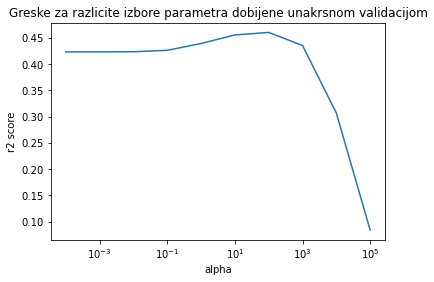

In [171]:
# nacrtajmo r2 skor na validacionom skupu za razlicite vrednosti parametra alpha
plt.plot(alphas, validation_scores)
plt.title('Greske za razlicite izbore parametra dobijene unakrsnom validacijom')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.show()

In [172]:
print('R2 skor na skupu za validaciju: %.2f' %optimal_score) 

R2 skor na skupu za validaciju: 0.46


In [173]:
print('Optimalna vrednost parametra alpha: ', optimal_alpha)

Optimalna vrednost parametra alpha:  100.0


In [174]:
# sada sa ovim optimalnim alfa pravimo model:

In [175]:
scaler.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler.transform(X_test[:, 0:4])

In [176]:
# model
ridge_regression = linear_model.Ridge(alpha=optimal_alpha)

In [177]:
# treniranje modela
ridge_regression.fit(X_train_and_validation, y_train_and_validation)

Ridge(alpha=100.0)

In [178]:
# evaluacija 
ridge_regression_score = ridge_regression.score(X_test, y_test)

In [179]:
ridge_regression_mse = metrics.mean_squared_error(y_test, ridge_regression.predict(X_test))
ridge_regression_absolute = metrics.mean_absolute_error(y_test, ridge_regression.predict(X_test))

In [180]:
print('R2 skor za model linearne regresije sa l2 regularizacijom: %.2f' %ridge_regression_score) 
print('MSE za model linearne regresije sa l2 regularizacijom: %.2f' %ridge_regression_mse) 
print('Srednja apsolutna greska za model linearne regresije sa l2 regularizacijom: %.2f' %ridge_regression_absolute) 

R2 skor za model linearne regresije sa l2 regularizacijom: 0.51
MSE za model linearne regresije sa l2 regularizacijom: 121.35
Srednja apsolutna greska za model linearne regresije sa l2 regularizacijom: 8.00


In [181]:
# vidimo da je mnogo bolja greska cim smo uradili regularizaciju

# Linearna regresija sa l1 regularizacijom (lasso regression)

In [182]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

In [183]:
# i ovde imamo regularizacioni parametar 
# uzecemo iste alfe kao i malopre

In [184]:
alphas

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])

In [185]:
# unakrsnom validacijom biramo optimalno alpha
optimal_score = 0
optimal_alpha = 0
validation_scores = []

for alpha in alphas:
    model = linear_model.Lasso(alpha=alpha)
    scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
    score = sum(scores)/len(scores)
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_alpha = alpha

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293490.39839385625, tolerance: 118.40295278220891
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151661.23535811098, tolerance: 118.40295278220891
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.81572860106826, tolerance: 118.40295278220891
  model = cd_fast.enet_coordinate_descent(


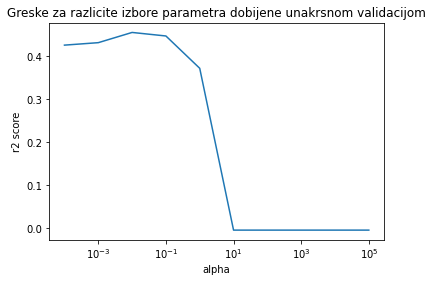

In [186]:
# crtamo grafika r2 skora na validacionom skupu za razlicite alphe
plt.plot(alphas, validation_scores)
plt.title('Greske za razlicite izbore parametra dobijene unakrsnom validacijom')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.show()

In [187]:
print('R2 skor na skupu za validaciju: %.2f' %optimal_score) 

R2 skor na skupu za validaciju: 0.45


In [188]:
print('Optimalna vrednost parametra alpha: ', optimal_alpha)

Optimalna vrednost parametra alpha:  0.01


In [189]:
# sada sa ovim alfa pravimo konacan model

In [190]:
scaler.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler.transform(X_test[:, 0:4])

In [191]:
# model
lasso_regression = linear_model.Lasso(alpha=optimal_alpha)

In [192]:
# treniranje 
lasso_regression.fit(X_train_and_validation, y_train_and_validation)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.1643970130244, tolerance: 128.7780528342195
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [193]:
# evaluacija
lasso_regression_score = lasso_regression.score(X_test, y_test)

In [194]:
lasso_regression_mse = metrics.mean_squared_error(y_test, lasso_regression.predict(X_test))
lasso_regression_absolute = metrics.mean_absolute_error(y_test, lasso_regression.predict(X_test))

In [195]:
print('R2 skor za model linearne regresije sa l1 regularizacijom: %.2f' %lasso_regression_score) 
print('MSE za model linearne regresije sa l1 regularizacijom: %.2f' %lasso_regression_mse) 
print('Srednja apsolutna greska za model linearne regresije sa l1 regularizacijom: %.2f' %lasso_regression_absolute) 

R2 skor za model linearne regresije sa l1 regularizacijom: 0.51
MSE za model linearne regresije sa l1 regularizacijom: 120.39
Srednja apsolutna greska za model linearne regresije sa l1 regularizacijom: 7.96


In [196]:
lasso_regression.coef_

array([ 7.54743512e-01,  3.43401942e+00,  4.05011162e-01,  8.50213352e-01,
       -2.08976513e+00, -6.44386447e-01,  2.23738683e-01, -0.00000000e+00,
       -0.00000000e+00,  5.92231460e-01, -2.42074218e+00, -1.01926511e+00,
        1.74153348e+00, -1.20686158e+00, -0.00000000e+00,  6.90571607e-01,
        1.91326525e+00,  4.49193746e-01,  0.00000000e+00,  3.12304913e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  2.11407384e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.70367078e+00,  0.00000000e+00,
       -2.12783275e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.60847599e+00,
       -3.33411795e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -9.99608508e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

Prva 4 koeficijenta su uz numericke atribute, i oni nisu 0. Peti i sesti koeficijent su uz atribute koje smo ordinalno enkodirali, i oni takodje nisu 0. Vidimo da imamo nule samo uz neke od atributa koji su enkodirani pomocu OneHotEncoder-a. To su kategoricki atributi.

# Poredjenje rezultata linearne regresije sa i bez regularizacije

In [197]:
print('Srednja kvadratna greska:')
print('Linearna regresija: %.2f' %linear_regression_mse)
print('Linearna regresija sa l2 regularizacijom: %.2f' %ridge_regression_mse)
print('Linearna regresija sa l1 regularizacijom: %.2f' %lasso_regression_mse)

Srednja kvadratna greska:
Linearna regresija: 500604991357024534528.00
Linearna regresija sa l2 regularizacijom: 121.35
Linearna regresija sa l1 regularizacijom: 120.39


In [198]:
print('Srednja apsolutna greska:')
print('Linearna regresija: %.2f' %linear_regression_absolute)
print('Linearna regresija sa l2 regularizacijom: %.2f' %ridge_regression_absolute)
print('Linearna regresija sa l1 regularizacijom: %.2f' %lasso_regression_absolute)

Srednja apsolutna greska:
Linearna regresija: 777758216.66
Linearna regresija sa l2 regularizacijom: 8.00
Linearna regresija sa l1 regularizacijom: 7.96


In [199]:
print('R2 score:')
print('Linearna regresija: %.2f' %linear_regression_score)
print('Linearna regresija sa l2 regularizacijom: %.2f' %ridge_regression_score)
print('Linearna regresija sa l1 regularizacijom: %.2f' %lasso_regression_score)

R2 score:
Linearna regresija: -2033557816097715712.00
Linearna regresija sa l2 regularizacijom: 0.51
Linearna regresija sa l1 regularizacijom: 0.51


Za model linearne regresije sa l1 regularizacijom imamo najbolje rezultate:
MSE = 120.39,
MAE = 7.96,
R2 = 0.51.

# Metoda potpornih vektora za regularizaciju (SVR)

In [200]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

In [201]:
# koristicemo RBF kernel - on ima parametar gamma
# takodje imamo i parametar regularizacije C

In [202]:
gammas = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
Cs = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])

In [203]:
optimal_score = 0 
optimal_gamma = 0
optimal_C = 0
validation_scores = []

for gamma in gammas:
    for C in Cs:
        model = svm.SVR(kernel='rbf', gamma=gamma, C=C)
        scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
        score = sum(scores)/len(scores)
        validation_scores.append(score)
        
        if score > optimal_score: 
            optimal_score = score
            optimal_gamma = gamma
            optimal_C = C

In [57]:
print('R2 skor na skupu za validaciju: %.2f' %optimal_score) 

R2 skor na skupu za validaciju: 0.42


In [58]:
print('Optimalna vrednost parametra gamma: ', optimal_gamma)
print('Optimalna vrednost parametra C: ', optimal_C)

Optimalna vrednost parametra gamma:  0.001
Optimalna vrednost parametra C:  100.0


In [59]:
# sada sa ovim gamma praavimo konacan model

In [60]:
scaler.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler.transform(X_test[:, 0:4])

In [61]:
svm_regression = svm.SVR(kernel='rbf', gamma=optimal_gamma, C=optimal_C)

In [62]:
# treniranje modela
svm_regression.fit(X_train_and_validation, y_train_and_validation)

SVR(C=100.0, gamma=0.001)

In [63]:
# evaluacija
svm_regression_score = svm_regression.score(X_test, y_test)

In [64]:
svm_regression_mse = metrics.mean_squared_error(y_test, svm_regression.predict(X_test))
svm_regression_absolute = metrics.mean_absolute_error(y_test, svm_regression.predict(X_test))

In [65]:
print('R2 skor za model potpornih vektora: %.2f' %svm_regression_score) 
print('MSE za model potpornih vektora: %.2f' %svm_regression_mse) 
print('Srednja apsolutna greska za model potpornih vektora: %.2f' %svm_regression_absolute) 

R2 skor za model potpornih vektora: 0.51
MSE za model potpornih vektora: 121.17
Srednja apsolutna greska za model potpornih vektora: 7.80


# Poredjenje rezultata

In [ ]:
# ne mozemo crtati rezultate za obicnu linearnu regresiju zato sto su ogromni brojevi u odnosu na ostale modele

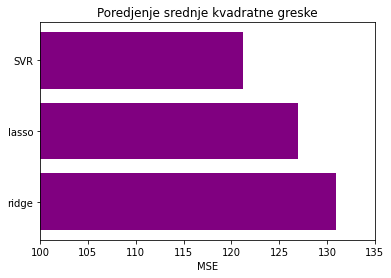

In [102]:
plt.barh([0, 1, 2], [ridge_regression_mse, lasso_regression_mse, svm_regression_mse], color='purple')
plt.title('Poredjenje srednje kvadratne greske')
plt.yticks([0, 1, 2], ['ridge', 'lasso', 'SVR'])
plt.xlabel('MSE')
plt.xlim([100, 135])
plt.show()

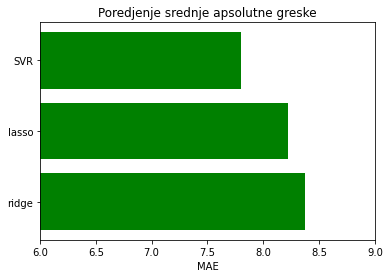

In [103]:
plt.barh([0, 1, 2], [ridge_regression_absolute, lasso_regression_absolute, svm_regression_absolute], color='green')
plt.title('Poredjenje srednje apsolutne greske')
plt.yticks([0, 1, 2], ['ridge', 'lasso', 'SVR'])
plt.xlabel('MAE')
plt.xlim([6, 9])
plt.show()

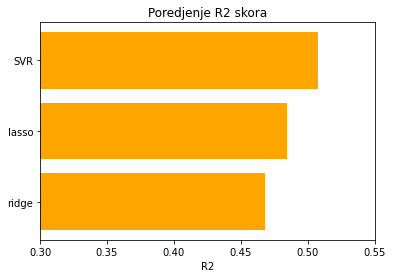

In [107]:
plt.barh([0, 1, 2], [ridge_regression_score, lasso_regression_score, svm_regression_score], color='orange')
plt.title('Poredjenje R2 skora')
plt.yticks([0, 1, 2], ['ridge', 'lasso', 'SVR'])
plt.xlabel('R2')
plt.xlim([0.3, 0.55])
plt.show()

Konacno, zakljucujemo da je najbolji model regresije model potpornih vektora sa parametrima gama = 0.001, C = 100.

Za ovaj model dobili smo: MSE = 121.17, MAE = 7.8, R2 = 0.51.